# 7. Bayesian inference 2 - encapsulating models

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/07_bayesian_inference_2.ipynb)

__Date__: Wednesday, Sept 11, 2024

## Learning outcomes
- defining complex Bayesian models
- connection between Bayesian models and directed acyclic graphs
- encapsulating Bayesian models with a `tfd.JointDistributionCoroutine`


## Bayesian models

In the previous session, we looked at several aspects of Bayesian inference including probability distributions of data, key mathematical considerations of distribution choices, and stimating parameters based on data. We now want to bring this all together within the context of epidemic models by encapsulating these aspects of our models so we can use more complex inference schemes.

Bayesian inference is a broad term that refers to the formulation and computation of the conditional probability $p(\theta | x) \propto p(\theta) p(X|\theta)$. The collection of prior distributions $p(\theta)$ along with the likelihood function $p(X|\theta)$ is what we refer to as our __Bayesian model__. In the [epidemic likelihoods](https://colab.research.google.com/drive/1fUAT9ALNNYJHQeMPxLUjgLB3US_Z8rb6) session, the likelihood function was defined using the $L(\theta| X)$ notation (a function of the model parameters). These two are used interchangeably in the literature (which can be somewhat confusing).

We want to develop a Bayesian workflow that can be followed and repeated when doing any modelling exercise. This typically includes three steps
1. model building
2. inference
3. model checking/improvement
This section will focus on the first step of this process - model building.

A big advantage of a Bayesian modelling approach is the clear flow of information which links model parameters to the data generating process. In order to build a Bayesian model, it is best to think about _how_ the observed data Y was generate from a process (and our goal is to  make a model which represents the process). With epidemics, the data we often see are case counts which can be modelled with a Poisson process as shown earlier. This can be represented with a Directed Acyclic Graph (DAG) which is a collection of verticies and edges that are directed from one vertex to another, but never form a closed loop. We use use them to represent the connections and dependencies in Bayesian models. Take the example of the chain binomial SIR model we used in the [epidemic likelihoods](https://colab.research.google.com/drive/1fUAT9ALNNYJHQeMPxLUjgLB3US_Z8rb6) session. The DAG for that model can be written as

In [ ]:
# @title
!apt update
!apt install imagemagick
!apt install pdf2svg
!apt install texlive texlive-latex-extra
!apt install amsmath

!pip install git+https://github.com/mkrphys/ipython-tikzmagic.git

In [ ]:
# @title
%load_ext tikzmagic

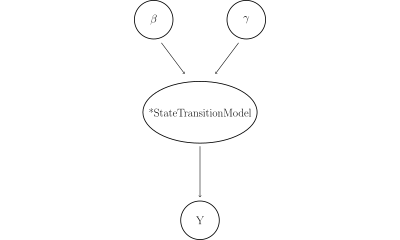

In [ ]:
%%tikz -S test_output.tikz -f svg

% priors
\draw [line width=1.5pt ] (2, 15) circle (1.25cm)  node {\huge $\beta$};
\draw [line width=1.5pt ] (8, 15) circle (1.25cm) node {\huge $\gamma$} ;

% model
\draw [line width=1.5pt ] (5,9) ellipse (3.7cm and 2.cm) node {\huge *StateTransitionModel};

% data
\draw [line width=1.5pt ] (5,2) circle (1.25cm) node {\huge Y} ;

% lines
\draw [line width=1pt, ->] (2.5, 13.5) -- (4, 11.5);
\draw [line width=1pt, ->] (7.5, 13.5) -- (6, 11.5);
\draw [line width=1pt, ->] (5, 6.8) -- (5, 3.5);

The top two nodes are the priors on the model parameters, $\beta,
\gamma$, the middle node is the model itself (can use any of the `*StateTransitionModel` types within `gemlib`), and the output of the DAG is the observed data $Y$.

We can wrap this DAG up in a function which we can turn into a JointDistributionCoroutine. The rest of this session will be implemented using Tensorflow as opposed to Numpy (with the exceptions of defining constants).  

In [ ]:
from warnings import warn

try:
    import google.colab
    !pip install gemlib
except:
    warn("Not running in Colab, make sure `gemlib` is installed locally")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 764.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.6/131.6 kB 947.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp


import gemlib
from gemlib.distributions import DiscreteTimeStateTransitionModel

tfd = tfp.distributions
sns.set()

DTYPE = tf.float32

## `tfd.JointDistributionCoroutine`

In TensorFlow Probability (TFP), `JointDistributionCoroutine` is a flexible way to define complex probabilistic models such as our epidemic models. It allows us to create a joint distribution that lets you specify how the different random variables in your model are related _and_ their distributions. The advantage is that it acts as a container for the priors and likelihood. The law of total conditional probability which we saw in the previous sessions means log-probabilities of the entire model can be calculated automatically by the library..

__Key Concepts__

- _Joint distributions_ : a joint distribution represents a probability distribution over multiple random variables. In this case, `JointDistributionCoroutine` enables you to model such distributions using coroutines. Tensorflow `JointDistribution`s act as an implementation of the chain rule of probability.
- _Coroutines_ : a coroutine is a function that can yield values, which allows it to be paused and resumed. `JointDistributionCoroutine` leverages this to allow for realizations of the process to be sampled from the prior level, all the way up to the data generating model in a step-by-step fashion.

__How It Works__

When defining a `JointDistributionCoroutine`, we are creating a generator function that yields the distributions of the model's random variables. The yield statements define the distribution of each variable, and can depend on previously defined variables (hence the chain rule of probability). This approach is useful when the dependencies between the random variables are complex

Here is a simple example using a Normal distribution.


In [ ]:
def model():
    # Define the prior for a mean
    x = yield tfd.Normal(loc=0., scale=1., name='prior_mean')

    sigma = tf.constant(2., DTYPE)

    # Define another variable whose distribution depends on the previous variable
    y = yield tfd.Normal(loc=x, scale=sigma, name='y')

joint = tfd.JointDistributionCoroutine(model)

### Exercise 1

Write (mathematically) the `model` equations defined above.

__Hint:__ it is a hierarchical model. No code required.

### Solution



Unlike typical Bayesian heirarchical models, `JointDistributionCoroutine`s are written bottom up.

_Computationally_
\begin{align}
x &\sim N(0,1) \\
\sigma &= 2 \\
y &\sim N(x, \sigma)
\end{align}

_Mathematically_
\begin{align}
y &\sim N(x, \sigma) \\
x &\sim N(0,1) \\
\sigma &= 2
\end{align}

With this structure, its easy to see how this can be extended to more complex examples.

## Using the Distribution

The big advantage of wrapping a model in this way is that we can get the log-probability of the model and sample from the model using only 1 object.

In [ ]:
# simulate the full model
joint.sample(seed = [1400,2000])

StructTuple(
  prior_mean=<tf.Tensor: shape=(), dtype=float32, numpy=-0.57661337>,
  y=<tf.Tensor: shape=(), dtype=float32, numpy=-0.53324795>
)

In [ ]:
# log-prob of a full sample
joint.log_prob(joint.sample(seed = [1400,2000]))

<tf.Tensor: shape=(), dtype=float32, numpy=-2.6975007>

What about more than 1 sample at a time? You may have noticed that if you try to draw more than 1 sample from `joint` there is an error. This happens because of underlying shape matching that Tensorflow does so that the library can perform automatic vectorization under the hood. To help the library in doing this, we can specify our model parameters as "roots" of the process.

In [ ]:
Root = tfd.JointDistributionCoroutine.Root

In [ ]:
def model():
    # Define the prior for a mean
    x = yield Root(tfd.Normal(loc=0., scale=1., name='prior_mean'))

    sigma = tf.constant(2., DTYPE)

    # Define another variable whose distribution depends on the previous variable
    y = yield tfd.Normal(loc=x, scale=sigma, name='y')

joint = tfd.JointDistributionCoroutine(model)

In [ ]:
joint.sample(10)

StructTuple(
  prior_mean=<tf.Tensor: shape=(10,), dtype=float32, numpy=
    array([-0.70670503, -1.2847158 , -1.0214878 ,  0.6846757 , -0.40034804,
           -0.09518702, -0.5109385 , -0.65681934,  0.15588532, -0.44213277],
          dtype=float32)>,
  y=<tf.Tensor: shape=(10,), dtype=float32, numpy=
    array([-4.33926   ,  2.2398062 ,  1.214856  ,  4.4924593 , -1.8010638 ,
            4.584976  , -0.24017268, -0.6215038 ,  3.2665422 ,  2.0059862 ],
          dtype=float32)>
)

This now takes 10 samples from the root of the distribution _and_ the accompanying 10 realizations of the process $Y$.

In [ ]:
# set a seed to control the randomness
joint.sample(seed = [1400,2000])

StructTuple(
  prior_mean=<tf.Tensor: shape=(), dtype=float32, numpy=-0.57661337>,
  y=<tf.Tensor: shape=(), dtype=float32, numpy=-0.53324795>
)

### Exercise 2

Specify a prior on sigma in the model above and create a histogram of 100 samples of $Y$.

### Solution

We start by writing the model and changing the constant value of $\sigma$ to a "Root" distribution.

In [ ]:
def model_sigma_prior():
    # Define the prior for a mean
    x = yield Root(tfd.Normal(loc=0.,
                              scale=1.,
                              name='prior_mean'))

    # Change here!
    sigma = yield Root(tfd.Gamma(concentration = 0.5,
                                 rate=4.,
                                 name = 'scale_prior'))

    # Define another variable whose distribution depends on the previous variable
    y = yield tfd.Normal(loc=x, scale=sigma, name='y')

joint_sigma_prior = tfd.JointDistributionCoroutine(model_sigma_prior)

In [ ]:
# Sample 100 realizations of the process
# 1 realization = tuple of [x, sigma, y] as sampled from
# model_sigma_prior in that order
joint_sigma_prior.sample(100)

StructTuple(
  prior_mean=<tf.Tensor: shape=(100,), dtype=float32, numpy=
    array([-0.9551072 , -0.10122427,  1.2294688 , -1.9954122 ,  0.5470924 ,
           -1.3876865 ,  0.67780125, -1.8434027 ,  0.830301  ,  0.35935163,
           -0.8001057 ,  0.47814107,  0.46240357, -0.8730347 , -0.94857633,
           -1.0841489 ,  1.5837051 , -0.16613734, -0.30622277,  0.93848115,
            0.87091   ,  0.06237912, -0.58966804,  0.8580771 , -1.0701789 ,
           -1.2843343 , -0.4309639 , -0.6384684 , -0.73687387,  0.81129986,
           -0.5983567 ,  0.5730538 , -1.0946702 , -0.3280778 ,  1.4605002 ,
           -0.14814802, -0.41553184,  1.4812213 , -1.4207405 , -0.591879  ,
           -0.03091043, -1.9021264 ,  0.13790208,  0.03995872, -1.104647  ,
           -0.85874224, -0.01774452, -0.9013453 ,  0.4298454 ,  0.23432447,
            2.450226  ,  1.2524738 ,  0.01148694, -1.7087393 ,  0.39822307,
           -0.15875672, -0.0060252 ,  0.23245104, -0.2372093 ,  1.0138267 ,
            1.

In [ ]:
# plot the histogram
joint_realizations = joint_sigma_prior.sample(100)

In [ ]:
joint_realizations.y            # can access by name or index

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([-1.6145159 , -1.5571012 ,  0.35415703,  0.09121737,  0.6258109 ,
       -0.28487128,  0.33133358,  0.05918488, -0.04337955, -0.44753057,
       -0.33698452, -2.1689749 , -2.560175  ,  0.92912036, -0.5126354 ,
        1.0483452 ,  0.86895484,  0.48659152, -1.1666516 , -0.31876743,
       -1.1955886 , -1.5721037 ,  1.588495  ,  0.20821443, -1.2983066 ,
       -0.10127602,  0.29793277, -1.478941  , -1.1370432 ,  0.6307083 ,
       -0.22037172, -0.34818605,  0.47726765, -0.625561  ,  0.48827583,
       -0.68831605, -0.3400755 ,  0.42631912,  0.43361092,  2.221074  ,
       -0.23744841,  0.16906661,  0.96824956, -0.90737116, -0.14986311,
       -0.7869214 ,  0.3305405 , -0.9993202 ,  0.9202349 ,  0.8238548 ,
        0.7656449 , -1.2000307 , -0.94423604,  0.21671   ,  1.1070442 ,
       -1.0908668 , -0.78636014,  0.33064163,  0.15598108,  0.29931998,
       -1.6509953 , -1.1506859 , -1.3023723 ,  0.5288177 ,  0.9708018 ,
        1.484355

Text(0.5, 1.0, 'Histogram of Values')

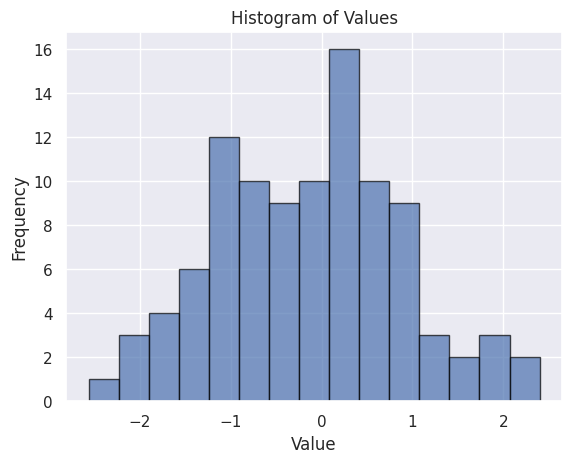

In [ ]:
# histogram
plt.hist(joint_realizations.y,
         bins=15,
         alpha = 0.7,
         edgecolor='black')  # Adjust 'bins' as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

### Sampling with fixed components

What about 10 samples from the same value of a prior? Remember that we are using the chain rule of probability so we need a way to _fix_ the value of the prior parameters. This can be done using a partial evaluation of the model function where we yield _only_ 1 value of the priors, then call the subsequent yields 10 times. Tensorflow allows us to do this using a method called `experimental_pin`.

In [ ]:
# simulate a value from our prior distribution of x
joint.sample(seed = [1400,2000]).prior_mean


<tf.Tensor: shape=(), dtype=float32, numpy=-0.57661337>

In [ ]:
# "pin" or condition the model on the prior simulation realization above
conditioned_model = joint.experimental_pin(
    prior_mean = joint.sample(seed = [1400,2000]).prior_mean
)

In [ ]:
conditioned_model

<tfp.distributions.JointDistributionPinned 'PinnedJointDistributionCoroutine' batch_shape=StructTuple(
  y=[]
) event_shape=StructTuple(
  y=[]
) dtype=StructTuple(
  y=float32
)>

In [ ]:
# sample the model
conditioned_model.sample_unpinned()

StructTuple(
  y=<tf.Tensor: shape=(), dtype=float32, numpy=0.7540533>
)

The `.sample_unpinned` method of the `tfp.distributions.JointDistributionPinned` object behaves the __same__ way as the `.sample` method of a `tfp.distributions.Distribution` object. The unpinned is a confusing name unfortunately, but there is a good reason for it. When a value in the distribution is "pinned", we are conditioning the remainder of the distribution it.

$$
\mbox{Set } x = 0.5 \Rightarrow y|x \sim N(0.5, \sigma)
$$

The program traces through the code in the original model and when it comes to the `x` value it checks if there is a specific value to set `x` to _OR_ if there is not, it generates one by sampling the distribution on the right side of the `yield` statement.

### Batched sampling

In [ ]:
# multiple samples - stem from the same start
prior_mean_sim = joint.sample(seed = [1400,2000]).prior_mean

conditioned_model_batched = joint.experimental_pin(
    prior_mean = tf.fill(dims = [10],
                         value = prior_mean_sim)
)

# To do: make a plot overlaying 3 different prior means

In [ ]:
conditioned_model_batched.sample_unpinned()

StructTuple(
  y=<tf.Tensor: shape=(10,), dtype=float32, numpy=
    array([ 1.9969168 ,  2.5153127 , -2.495037  , -3.4956398 , -2.9207215 ,
            0.53875023, -2.1790884 , -1.6320052 ,  0.7276158 ,  0.4485634 ],
          dtype=float32)>
)

### Exercise 3

Create a historgram which overlays samples from the following 3 conditional dsitributions of $y$.

1. $x = 0.5 \Rightarrow y|x \sim N(0.5, \sigma) $
2. $x = 2.5 \Rightarrow y|x \sim N(2.5, \sigma)$
3. $\sigma = 0.1 \Rightarrow y|x \sim N(x, 0.1)$

### Solution

In [ ]:
# sample 1

y_cond_x1 = joint_sigma_prior.experimental_pin(
    prior_mean = tf.fill(dims = [1000],
                         value = 0.5)
).sample_unpinned()


y_cond_x2 = joint_sigma_prior.experimental_pin(
    prior_mean = tf.fill(dims = [1000],
                         value = 2.5)
).sample_unpinned()

y_cond_sigma = joint_sigma_prior.experimental_pin(
    scale_prior = tf.fill(dims = [1000],
                         value = 0.1)
).sample_unpinned()


Text(0.5, 1.0, 'Histogram of Values')

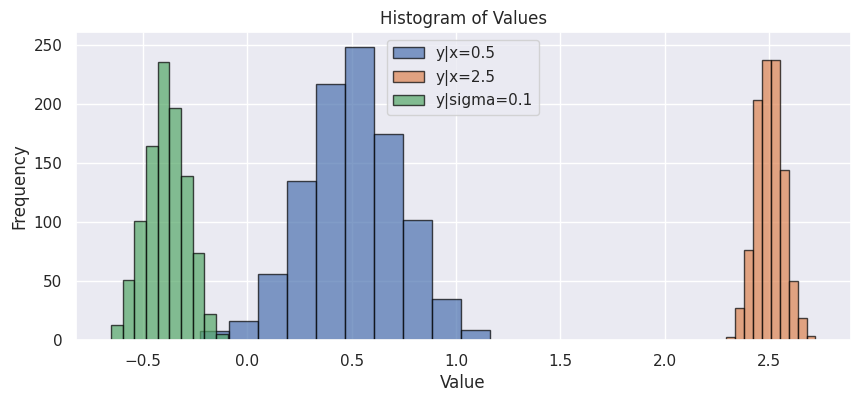

In [ ]:
# histogram
plt.figure(figsize = (10,4))
# plot x1
plt.hist(y_cond_x1.y,
         #bins=15,
         alpha = 0.7,
         edgecolor='black',
         label = 'y|x=0.5')
# plot x2
plt.hist(y_cond_x2.y,
         #bins=15,
         alpha = 0.7,
         edgecolor='black',
         label = 'y|x=2.5')
# plot sigma
plt.hist(y_cond_sigma.y,
         #bins=15,
         alpha = 0.7,
         edgecolor='black',
         label = 'y|sigma=0.1')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values')

## Incorporating `gemlib` models

The distributions we defined above give us a nice footprint for how to compose our epidemic models.
```
@tfd.JointDistributionCoroutine
def epi_model():
    # prior block
    | parameter1 = yield tfd...
    | parameter2 = yield tfd...
    |

    parameters = (parameter1, parameter2, ...)

    # transition rate function
    def transition_rate_fn(*parameters):
        |
        |
        return *rates
    
    model = yield *StateTransitionModel(**kwargs)
```

The `*StateTransitionModel` classes we've previously seen meet the Tensorflow criteria of a distribution so they can be used within a `JointDistributionCoroutine` to create the DAG of the model.

### Exercise 2

Take the SEIR model from the [Models in gemlib](https://gem-epidemics.gitlab.io/practical-epidemics/iddinf/02-intro-to-gemlib.html#discrete-time-stochastic-solver) session and wrap it in the `epi_model` footprint above.

__Suggestion:__ Keep model constants (those that relate to the structure of the model) outside of the `epi_model` function so they are easier to access.

### Solution

I am pulling the epidemic model constants (incidence matrix, connectivity matrix, initial population, and transition rate function) outside of the template above so I can have access to them as global variables and not need to dig through the `tfd.JointDistributionCoroutine` to find them.

In [ ]:
connectivity = np.array(
    [
        [0.0 , 0.5, 0.25],
        [0.5 , 0.0, 0.1 ],
        [0.25, 0.1, 0.0 ]
    ],
    dtype=np.float32
)

In [ ]:
incidence_matrix = np.array(
    [
        [-1,  0,  0],
        [ 1, -1,  0],
        [ 0,  1, -1],
        [ 0,  0,  1],
    ],
    dtype=np.float32
)

In [ ]:
initial_state = np.array(
    [  # S    E  I  R
        [99 , 0, 1, 0],  # n=0
        [100, 0, 0, 0],  # n=1
        [100, 0, 0, 0],  # n=2
    ],
    np.float32
)

In [ ]:
def make_transition_rate_fn(beta, psi, nu, gamma):
    def trf(t, state):
        within = state[:, 2]  # states are enumerated S, E, I, R from 0
        between = psi * tf.linalg.matvec(
            connectivity, state[:, 2] / tf.reduce_sum(state, axis=-1)
        )
        si_rate = beta * (within + between)
        ei_rate = tf.broadcast_to(nu, si_rate.shape)
        ir_rate = tf.broadcast_to(gamma, si_rate.shape)
        return si_rate, ei_rate, ir_rate
    return trf

In [ ]:
@tfd.JointDistributionCoroutine
def seir_meta_pop_model():
    # prior block
    beta = yield Root(tfd.HalfNormal(scale = 10., name = 'beta'))
    psi = yield Root(tfd.Gamma(concentration = 2., rate = 4., name = 'psi'))
    nu = yield Root(tfd.Gamma(concentration = 8., rate = 2., name = 'nu'))
    gamma = yield Root(tfd.HalfCauchy(loc = 0.,scale = 10., name = 'gamma'))

    # bundle parameters
    parameters = (beta, psi, nu, gamma)

    # create an instance of the transition rate function w/ prior sim parameters
    transition_rate_fn = make_transition_rate_fn(*parameters)

    # create the model
    seir = yield DiscreteTimeStateTransitionModel(
        transition_rate_fn=transition_rate_fn,
        incidence_matrix=incidence_matrix,
        initial_state=initial_state,
        num_steps=80,
        name = 'seir')

In [ ]:
seir = seir_meta_pop_model

In [ ]:
seir

<tfp.distributions.JointDistributionCoroutine 'JointDistributionCoroutine' batch_shape=StructTuple(
  beta=[],
  psi=[],
  nu=[],
  gamma=[],
  seir=[]
) event_shape=StructTuple(
  beta=[],
  psi=[],
  nu=[],
  gamma=[],
  seir=[80, 3, 3]
) dtype=StructTuple(
  beta=float32,
  psi=float32,
  nu=float32,
  gamma=float32,
  seir=float32
)>

In [ ]:
seir.sample()

StructTuple(
  beta=<tf.Tensor: shape=(), dtype=float32, numpy=5.780337>,
  psi=<tf.Tensor: shape=(), dtype=float32, numpy=0.61099535>,
  nu=<tf.Tensor: shape=(), dtype=float32, numpy=4.8489494>,
  gamma=<tf.Tensor: shape=(), dtype=float32, numpy=32.561745>,
  seir=<tf.Tensor: shape=(80, 3, 3), dtype=float32, numpy=
    array([[[99.,  0.,  1.],
            [ 5.,  0.,  0.],
            [ 1.,  0.,  0.]],
    
           [[ 0., 99.,  0.],
            [ 0.,  5.,  0.],
            [ 0.,  1.,  0.]],
    
           [[ 0.,  0., 99.],
            [95.,  0.,  5.],
            [99.,  0.,  1.]],
    
           [[ 0.,  0.,  0.],
            [ 0., 95.,  0.],
            [ 0., 97.,  0.]],
    
           [[ 0.,  0.,  0.],
            [ 0.,  0., 95.],
            [ 0.,  2., 97.]],
    
           [[ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  2.]],
    
           [[ 0.,  0.,  0.],
            [ 0.,  0.,  0.],
            [ 0.,  0.,  0.]],
    
           [[ 0.,  0.,  0.],
  

### Exercise 3

Simulate an epidemic with the following fixed parameter values.

\begin{align}
\beta &= 0.02 \\  
\nu &= 0.5 \\
\psi &= 0.06 \\
\gamma &= 0.2
\end{align}

Use 3 graphs plotting the number of transition events to explain what happens to the progression of the epidemic as connectivity parameter $\psi$ increases (i.e. use 3 increasing values of $\psi$).

### Solution

In [ ]:
conditioned_seir = seir.experimental_pin(
    beta = 0.02,
    nu = 0.05,
    psi = 0.6,          # change me :)
    gamma = 0.2
    )

In [ ]:
simulation = conditioned_seir.sample_unpinned()

Import plotting code from [Models in gemlib](https://gem-epidemics.gitlab.io/practical-epidemics/iddinf/02-intro-to-gemlib.html#discrete-time-stochastic-solver).

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
def plot_timeseries_counts(
        times, states, plot_height=4, labels=["SE", "EI", "IR"], alpha=1.0
):
    num_plots = states.shape[-2]
    fig, ax = plt.subplots(
        1, num_plots, figsize=(num_plots*plot_height*1.5, plot_height)
    )

    for i in range(num_plots):
        for s, label in enumerate(labels):
            state = np.transpose(states[..., i, s])
            ax[i].plot(
                np.transpose(times),
                np.cumsum(state),       # change to show cumulative events
                label=label,
                color=f"C{s}",
                alpha=alpha
            )
        ax[i].set_title("Subpopulation {}".format(i))
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Individuals")
        leg_lines = [Line2D([0], [0], color=f"C{i}") for i in range(len(labels))]
        ax[i].legend(leg_lines, labels)

    return fig, ax

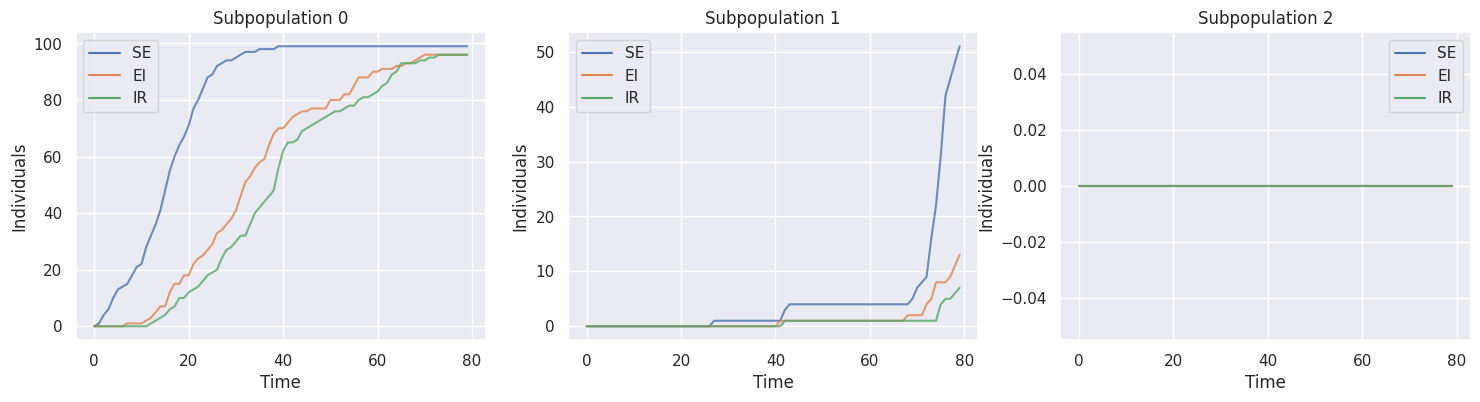

In [ ]:
_ = plot_timeseries_counts(np.arange(80), simulation[0], alpha=0.8)

As $\psi$ increases the mixing between the 3 populations increases and the epidemic takes of sooner in sub-population 1 and 2.


One of the tradeoffs for the convenience of the `tfd.JointDistributionCoroutine` is that we lose the methods of the `*StateTransitionModel*. If we want to plot the epidemic curves instead of the counts, we need to create an instance of the __same__ model that is _inside_ the distribution, outside of it as well.

In [ ]:
seir_again = DiscreteTimeStateTransitionModel(
        transition_rate_fn=make_transition_rate_fn(beta = 0.02,
                                                   nu = 0.05,
                                                   psi = 0.6,
                                                   gamma = 0.2),
        incidence_matrix=incidence_matrix,
        initial_state=initial_state,
        num_steps=80,
        name = 'seir')

In [ ]:
simulation.seir

<tf.Tensor: shape=(80, 3, 3), dtype=float32, numpy=
array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 3.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 2.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 4.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 3.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 1.,  1.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 3.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 3.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 6.,  1.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 4.,  1.,  1.],

In [ ]:
# now I can feed the realization of the coroutine into seir_again
seir_again.compute_state(simulation.seir) # dig out the realization of seir

<tf.Tensor: shape=(80, 3, 4), dtype=float32, numpy=
array([[[ 99.,   0.,   1.,   0.],
        [100.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.]],

       [[ 99.,   0.,   1.,   0.],
        [100.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.]],

       [[ 98.,   1.,   1.,   0.],
        [100.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.]],

       [[ 95.,   4.,   1.,   0.],
        [100.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.]],

       [[ 93.,   6.,   1.,   0.],
        [100.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.]],

       [[ 89.,  10.,   1.,   0.],
        [100.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.]],

       [[ 86.,  13.,   1.,   0.],
        [100.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.]],

       [[ 85.,  14.,   1.,   0.],
        [100.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.]],

       [[ 84.,  14.,   2.,   0.],
        [100.,   0.,   0.,   0.],
        [100.,   0.,   0.,   0.]],

       [[ 81

In [ ]:
def plot_timeseries_cruves(
        times, states, plot_height=4, labels=["S", "E", "I", "R"], alpha=1.0
):
    num_plots = states.shape[-2]
    fig, ax = plt.subplots(
        1, num_plots, figsize=(num_plots*plot_height*1.5, plot_height)
    )

    for i in range(num_plots):
        for s, label in enumerate(labels):
            state = np.transpose(states[..., i, s])
            ax[i].plot(
                np.transpose(times),
                state,
                label=label,
                color=f"C{s}",
                alpha=alpha
            )
        ax[i].set_title("Subpopulation {}".format(i))
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Individuals")
        leg_lines = [Line2D([0], [0], color=f"C{i}") for i in range(len(labels))]
        ax[i].legend(leg_lines, labels)

    return fig, ax

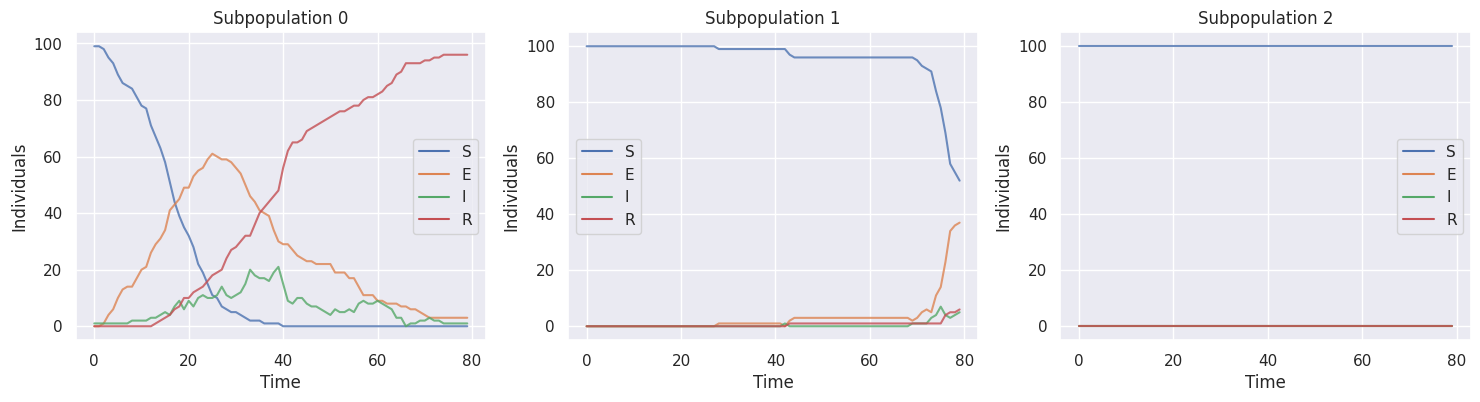

In [ ]:
_ = plot_timeseries_cruves(np.arange(80),
                           seir_again.compute_state(simulation.seir),
                           alpha=0.8)

## Finding MAPs

The `experimental_pin` method can also be used as a way to create a log-probability function for the model which allows us to compute _Maximum a Posteriori_ estimates of parameters. These can be thought of as the Bayesian MLE.


In [ ]:
# generate some data
simulated_dataset = conditioned_seir.sample_unpinned(seed = [11,9])

### Exercise
Write a function that evaluates the log-probability of the model and use `scipy.optimize.minimize` to find the optimal values.

### Solution

In [ ]:
def seir_log_prob(params_tuple):
    """
    Create a negative log-prob function for our model
    """
    params_dict = {'beta': params_tuple[0],
                   'nu': params_tuple[1],
                   'psi': params_tuple[2],
                   'gamma': params_tuple[3]}

    conditional_tlp = seir_meta_pop_model.experimental_pin(
        seir = simulated_dataset
    )
    return -conditional_tlp.log_prob(**params_dict)

In [ ]:
# need to use named arguments with experimental_pin
seir_log_prob([0.02, 0.05, 0.6, 0.2])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([477.45853], dtype=float32)>

In [ ]:
from scipy.optimize import minimize

In [ ]:
# this may take a while (up to 5min)
mle = minimize(fun = seir_log_prob,
               x0 = [0.01, 0.01, 0.01, 0.01],
               method="L-BFGS-B",
               jac="3-point",
               options={"finite_diff_rel_step": None},
               )

In [ ]:
print(f"True values: {[0.02, 0.05, 0.6, 0.2]}"),
print(f"Estimated values: {[round(x, 3) for x in mle.x]}")


True values: [0.02, 0.05, 0.6, 0.2]
Estimated values: [0.023, 0.051, 0.071, 0.207]




For the remainder of the time, try to implement your own model using the `epi_model` pattern.